In [1]:
from thetis import *
from firedrake_adjoint import *

In [2]:
import adolc
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [3]:
from adapt_utils.case_studies.tohoku.options.okada_options import TohokuOkadaBasisOptions
from adapt_utils.norms import vecnorm
from adapt_utils.unsteady.solver import AdaptiveProblem

Following the parameter redundancy experiment, we only allow variations in slip.

In [4]:
taylor = False
num_mins = 2
kwargs = dict(end_time=num_mins*60, synthetic=False)
op = TohokuOkadaBasisOptions(**kwargs)
op.active_controls = ['slip']
num_active_controls = len(op.active_controls)
gauges = list(op.gauges.keys())
tp = AdaptiveProblem(op, nonlinear=False)

Annotate the source model to ADOL-C's tape

In [5]:
tape_tag = 0
tp.set_initial_condition(annotate_source=True, tag=tape_tag, separate_faults=False)
stats = adolc.tapestats(tape_tag)
for key in stats:
    print("ADOL-C: {:20s}: {:d}".format(key.lower(), stats[key]))
num_subfaults = len(op.subfaults)
q = tp.fwd_solution
q0 = q.copy(deepcopy=True)

ADOL-C: num_independents    : 190
ADOL-C: num_dependents      : 1800
ADOL-C: num_max_lives       : 524288
ADOL-C: tay_stack_size      : 0
ADOL-C: op_buffer_size      : 50000000
ADOL-C: num_operations      : 1372933
ADOL-C: op_file_access      : 0
ADOL-C: num_locations       : 3425924
ADOL-C: loc_file_access     : 0
ADOL-C: num_values          : 685140
ADOL-C: val_file_access     : 0
ADOL-C: loc_buffer_size     : 50000000
ADOL-C: val_buffer_size     : 50000000
ADOL-C: tay_buffer_size     : 50000000


Set initial condition for tsunami propagation

In [6]:
tape = get_working_tape()
tape.clear_tape()
u, eta = q.split()
u0, eta0 = q0.split()
u.assign(0.0)
eta.assign(eta0)
controls = Control(eta)

Setup QoI

In [7]:
op.get_update_forcings(tp, 0)
wq = Constant(0.0)
op.J = 0

def update_forcings(t):
    tt = t - op.dt
    for gauge in gauges:
        tstart = op.gauges[gauge]['arrival_time']
        tend = min(op.gauges[gauge]['departure_time'], op.end_time)
        if t < tstart or t > tend:
            continue
        wq.assign(0.25*op.dt if np.isclose(tt, tstart) or np.isclose(tt, tend) else 0.5*op.dt)
        op.gauges[gauge]['obs'].assign(op.gauges[gauge]['interpolator'](tt))
        op.J = op.J + assemble(wq*op.gauges[gauge]['indicator']*(eta - op.gauges[gauge]['obs'])**2*dx)

Run tsunami propagation, annotating pyadjoint's tape

In [8]:
tp.setup_solver_forward_step(0)
tp.solve_forward_step(0, update_forcings=update_forcings)
J = op.J
stop_annotating()
Jhat = ReducedFunctional(J, controls)

FORWARD SOLVE  time     0.00  (  0.00) seconds
    elevation norm           at time   60.0 =  1.0584e+06
    velocity norm            at time   60.0 =  2.2900e+04
FORWARD SOLVE  time    60.00  (  2.45) seconds
    elevation norm           at time  120.0 =  8.6471e+05
    velocity norm            at time  120.0 =  3.8247e+04
FORWARD SOLVE  time   120.00  (  1.05) seconds


In [9]:
def reduced_functional(m):
    """
    Compose both unrolled tapes
    """
    m_array = m.reshape((num_active_controls, num_subfaults))
    for i, control in enumerate(op.active_controls):
        assert len(op.control_parameters[control]) == len(m_array[i])
        op.control_parameters[control][:] = m_array[i]

    # Unroll ADOL-C's tape
    op.set_initial_condition(tp, unroll_tape=True, separate_faults=False, tag=tape_tag)
    u, eta = tp.fwd_solution.split()

    # Unroll pyadjoint's tape
    op.J = Jhat(eta)
    print("Reduced functional = {:.8e}".format(op.J))
    return op.J

In [10]:
def gradient(m):
    """
    Apply the chain rule to both tapes
    """

    # Reverse propagate on pyadjoint's tape
    dJdeta0 = Jhat.derivative()

    # Restrict to source region
    dJdeta0 = interpolate(dJdeta0, tp.P1[0])  # TODO: Avoid interpolation
    dJdeta0 = dJdeta0.dat.data[op.indices]

    # Reverse propagate on ADOL-C's tape
    dJdm = adolc.fos_reverse(tape_tag, dJdeta0)
    print("Gradient norm      = {:.8e}".format(vecnorm(dJdm, order=np.Inf)))
    return dJdm

In [11]:
c = np.array(op.control_parameters['slip']).flatten()

In [12]:
op.control_trajectory = []
op.qoi_trajectory = []

In [13]:
def callback(m):
    op.control_trajectory.append(m)
    op.qoi_trajectory.append(op.J)
    print("LINE SEARCH COMPLETE")

In [14]:
# Run optimisation
print_output("Optimisation begin...")
opt_kwargs = {
    'maxiter': 1000,
    'gtol': 1.0e-02,
    'fprime': gradient,
    'callback': callback,
}
optimised_value = scipy.optimize.fmin_bfgs(reduced_functional, c, **opt_kwargs)

Optimisation begin...


Reduced functional = 7.08918674e+02
Gradient norm      = 1.51466274e+00
Reduced functional = 6.86002153e+02
Gradient norm      = 1.45359372e+00
Reduced functional = 6.03971133e+02
Gradient norm      = 1.20931764e+00
LINE SEARCH COMPLETE
Reduced functional = 3.84986612e+02
Gradient norm      = 1.03060548e+00
LINE SEARCH COMPLETE
Reduced functional = 3.45969074e+02
Gradient norm      = 1.07433608e+00
LINE SEARCH COMPLETE
Reduced functional = 1.56833766e+02
Gradient norm      = 9.68915665e-01
LINE SEARCH COMPLETE
Reduced functional = 1.12950709e+02
Gradient norm      = 5.36085697e-01
LINE SEARCH COMPLETE
Reduced functional = 9.57956729e+01
Gradient norm      = 2.77221824e-01
LINE SEARCH COMPLETE
Reduced functional = 9.22724585e+01
Gradient norm      = 2.63798356e-01
LINE SEARCH COMPLETE
Reduced functional = 8.34201794e+01
Gradient norm      = 1.97251825e-01
LINE SEARCH COMPLETE
Reduced functional = 7.26664107e+01
Gradient norm      = 1.50483934e-01
LINE SEARCH COMPLETE
Reduced functional 

KeyboardInterrupt: 

In [31]:
m_array = op.control_trajectory[0].reshape((num_active_controls, num_subfaults))
for i, control in enumerate(op.active_controls):
    assert len(op.control_parameters[control]) == len(m_array[i])
    op.control_parameters[control][:] = m_array[i]
eta0 = op.set_initial_condition(tp, unroll_tape=True, separate_faults=False, tag=tape_tag)
m_array = op.control_trajectory[-1].reshape((num_active_controls, num_subfaults))
for i, control in enumerate(op.active_controls):
    assert len(op.control_parameters[control]) == len(m_array[i])
    op.control_parameters[control][:] = m_array[i]
eta = op.set_initial_condition(tp, unroll_tape=True, separate_faults=False, tag=tape_tag)

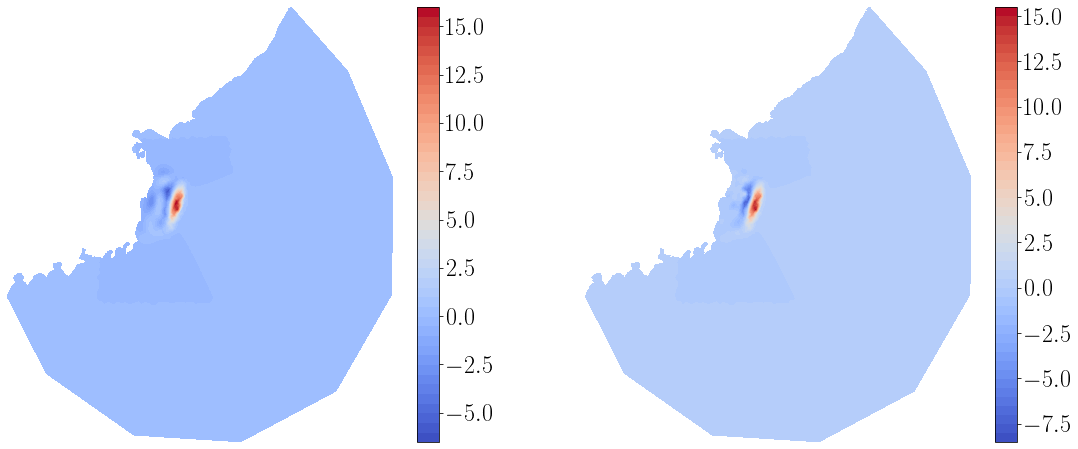

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(19, 8))
for i, f in enumerate((eta0, eta)):
    tc = tricontourf(f, axes=axes[i], cmap='coolwarm', levels=50)
    cbar = fig.colorbar(tc, ax=axes[i])
    axes[i].axis(False);

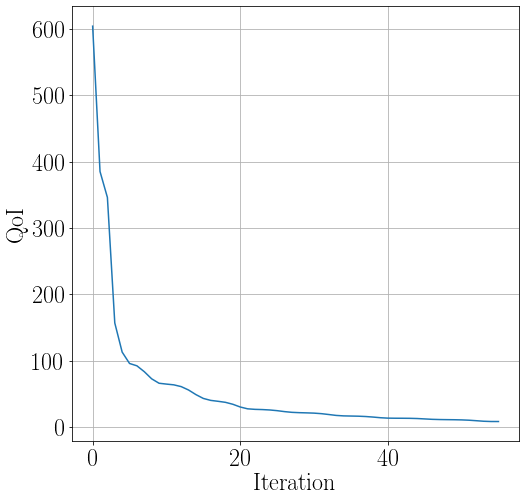

In [30]:
fig, axes = plt.subplots(figsize=(8, 8))
axes.plot(op.qoi_trajectory)
axes.set_xlabel("Iteration")
axes.set_ylabel("QoI")
axes.grid(True, which='both');

# TODO:
* Plot timeseries